<a href="https://colab.research.google.com/github/mohamed32145/U-net-image-segmantion-paper-implemeantion/blob/main/DLfinal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
experiment 2:

https://www.kaggle.com/competitions/data-science-bowl-2018/data
This dataset contains a large number of segmented nuclei images.
The images were acquired under a variety of conditions and vary in the cell type,
magnification, and imaging modality (brightfield vs. fluorescence). The dataset is
designed to challenge an algorithm's ability to generalize across these variations.

"""


"\nexperiment 2:\n\nhttps://www.kaggle.com/competitions/data-science-bowl-2018/data\nThis dataset contains a large number of segmented nuclei images.\nThe images were acquired under a variety of conditions and vary in the cell type,\nmagnification, and imaging modality (brightfield vs. fluorescence). The dataset is\ndesigned to challenge an algorithm's ability to generalize across these variations.\n\n"

In [ ]:
# Mount Google Drive and install required packages
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
#!pip install scikit-image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

#  paths for Google Drive
DRIVE_PATH = '/content/drive/MyDrive/data-science-bowl-2018/'
TRAIN_PATH = '/content/train/'
TEST_PATH = '/content/test/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


#  Dataset Class

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0  # Normalize to [0, 1] ,,8-bit images has image pixel values in the range [0, 255]
        mask = self.masks[idx].astype(np.float32)

        # Convert to torch tensors and rearrange dimensions (H, W, C) -> (C, H, W)
        image = torch.from_numpy(image).permute(2, 0, 1) # the tensor will be at the same memory of the original Numpy array
        mask = torch.from_numpy(mask).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image, mask


# U-Net Model Definition
# encoder path blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(0.1) # Randomly sets 10% of feature map activations to zero during training to reduce overfitting
        self.relu = nn.ReLU(inplace=True) # adds non-linearity: replaces negative values with zero.

        # Kaiming normal initialization
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        return x

                                             # decoder (expanding) path blok
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsampleBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2) # Upscales the feature map by a factor of 2 in height and width
        self.conv_block = ConvBlock(in_channels, out_channels)  # in_channels because of concatenation
# the ConvBlock applies two 3×3 convolutions after concatenation with the skip connection
# so affter we upsampling via ConvTranspose2d , we concatenate the upsampled feature map with the skip connection from the encoder — this doubles the channels
# and we want to keep the original number of channels not the doubled one
# example let's say
# x after upsampling: (B, 256, 32, 32)
# skip_connection from encoder: (B, 256, 32, 32)
# After concatenation: (B, 512, 32, 32)
# After ConvBlock: (B, 256, 32, 32) (channels reduced to match decoder output requirement)

    def forward(self, x, skip_connection):
        x = self.up(x)
        # Concatenate along channel dimension
        x = torch.cat([x, skip_connection], dim=1) # Concatenates the upsampled features with the corresponding encoder features (skip_connection)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (Contracting Path)
        self.conv1 = ConvBlock(in_channels, 16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = ConvBlock(16, 32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = ConvBlock(32, 64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = ConvBlock(64, 128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv5 = ConvBlock(128, 256)

        # Decoder (Expanding Path)
        self.up6 = UpsampleBlock(256, 128)
        self.up7 = UpsampleBlock(128, 64)
        self.up8 = UpsampleBlock(64, 32)
        self.up9 = UpsampleBlock(32, 16)

        # Output layer
        self.output = nn.Conv2d(16, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        c5 = self.conv5(p4)

        # Decoder
        c6 = self.up6(c5, c4)
        c7 = self.up7(c6, c3)
        c8 = self.up8(c7, c2)
        c9 = self.up9(c8, c1)

        # Output
        output = self.output(c9)
        output = self.sigmoid(output)

        return output


# Data Loading and Preprocessing

def load_data():
    print("Setting up directories...")

    # Create directories if they don't exist
    os.makedirs('/content/train', exist_ok=True)
    os.makedirs('/content/test', exist_ok=True)

    print("Extracting data from Google Drive...")
    # Check if zip files exist in Google Drive
    train_zip_path = os.path.join(DRIVE_PATH, 'stage1_train.zip')
    test_zip_path = os.path.join(DRIVE_PATH, 'stage1_test.zip')

    if not os.path.exists(train_zip_path):
        raise FileNotFoundError(f"Training data not found at {train_zip_path}. Please check your Google Drive path.")
    if not os.path.exists(test_zip_path):
        raise FileNotFoundError(f"Test data not found at {test_zip_path}. Please check your Google Drive path.")

    # Unzip data from Google Drive to Colab storage
    print("Extracting training data...")
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/train')

    print("Extracting test data...")
    with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/test')

    # Get list of all subfolders
    train_ids = next(os.walk(TRAIN_PATH))[1]
    test_ids = next(os.walk(TEST_PATH))[1]

    print(f"Found {len(train_ids)} training samples and {len(test_ids)} test samples")

    # Initialize arrays
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

    print("Loading training data...")
    # Load training data
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_

        # Read and process image
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img

        # Process masks
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask

    print("Loading test data...")
    # Load test data
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []

    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img

    print("Data loading completed!")
    return X_train, Y_train, X_test, sizes_test


# Training Function

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_batches = 0

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            accuracy = (predicted == masks).float().mean()
            train_acc += accuracy.item()
            train_batches += 1

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_batches = 0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()

                predicted = (outputs > 0.5).float()
                accuracy = (predicted == masks).float().mean()
                val_acc += accuracy.item()
                val_batches += 1

        # Calculate average losses and accuracies
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches
        avg_train_acc = train_acc / train_batches
        avg_val_acc = val_acc / val_batches

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print('-' * 50)

        # Save model to Google Drive for persistence
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_save_path = '/content/drive/MyDrive/best_unet_model.pth'
            torch.save(model.state_dict(), model_save_path)
            # Also save locally for immediate use
            torch.save(model.state_dict(), '/content/best_model.pth')
            patience_counter = 0
            print(f'Model saved with validation loss: {best_val_loss:.4f}')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


# Visualization Functions

def display_images(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def predict_and_visualize(model, X_data, Y_data, device, num_samples=3):
    model.eval()

    with torch.no_grad():
        for i in range(num_samples):
            idx = random.randint(0, len(X_data) - 1)

            # Prepare input
            image = X_data[idx:idx+1].astype(np.float32) / 255.0
            image_tensor = torch.from_numpy(image).permute(0, 3, 1, 2).to(device)

            # Make prediction
            prediction = model(image_tensor)
            prediction = prediction.cpu().numpy().squeeze()
            prediction_binary = (prediction > 0.5).astype(np.uint8)

            # Display results
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(X_data[idx])
            axes[0].set_title('Original Image')
            axes[0].axis('off')

            axes[1].imshow(Y_data[idx].squeeze(), cmap='gray')
            axes[1].set_title('Ground Truth Mask')
            axes[1].axis('off')

            axes[2].imshow(prediction_binary, cmap='gray')
            axes[2].set_title('Predicted Mask')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()



Using device: cuda


Setting up directories...
Extracting data from Google Drive...
Extracting training data...
Extracting test data...
Found 670 training samples and 65 test samples
Loading training data...


100%|██████████| 670/670 [04:39<00:00,  2.40it/s]


Loading test data...


100%|██████████| 65/65 [00:01<00:00, 49.18it/s]


Data loading completed!
Model Summary:
Total parameters: 1,941,105
Trainable parameters: 1,941,105
Starting training...


Epoch 1/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 21.21it/s]


Epoch [1/25]
Train Loss: 0.5279, Train Acc: 0.7542
Val Loss: 0.5196, Val Acc: 0.7091
--------------------------------------------------
Model saved with validation loss: 0.5196


Epoch 2/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 35.37it/s]


Epoch [2/25]
Train Loss: 0.4220, Train Acc: 0.7539
Val Loss: 0.4654, Val Acc: 0.7173
--------------------------------------------------
Model saved with validation loss: 0.4654


Epoch 3/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 35.29it/s]


Epoch [3/25]
Train Loss: 0.3436, Train Acc: 0.8428
Val Loss: 0.3638, Val Acc: 0.8605
--------------------------------------------------
Model saved with validation loss: 0.3638


Epoch 4/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 33.09it/s]


Epoch [4/25]
Train Loss: 0.2634, Train Acc: 0.8951
Val Loss: 0.2152, Val Acc: 0.9131
--------------------------------------------------
Model saved with validation loss: 0.2152


Epoch 5/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.73it/s]


Epoch [5/25]
Train Loss: 0.2180, Train Acc: 0.9114
Val Loss: 0.1598, Val Acc: 0.9379
--------------------------------------------------
Model saved with validation loss: 0.1598


Epoch 6/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 30.19it/s]


Epoch [6/25]
Train Loss: 0.1801, Train Acc: 0.9278
Val Loss: 0.1590, Val Acc: 0.9388
--------------------------------------------------
Model saved with validation loss: 0.1590


Epoch 7/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.63it/s]


Epoch [7/25]
Train Loss: 0.1687, Train Acc: 0.9354
Val Loss: 0.1359, Val Acc: 0.9476
--------------------------------------------------
Model saved with validation loss: 0.1359


Epoch 8/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 22.29it/s]


Epoch [8/25]
Train Loss: 0.1554, Train Acc: 0.9408
Val Loss: 0.1214, Val Acc: 0.9545
--------------------------------------------------
Model saved with validation loss: 0.1214


Epoch 9/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.61it/s]


Epoch [9/25]
Train Loss: 0.1418, Train Acc: 0.9459
Val Loss: 0.1194, Val Acc: 0.9564
--------------------------------------------------
Model saved with validation loss: 0.1194


Epoch 10/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 33.65it/s]


Epoch [10/25]
Train Loss: 0.1433, Train Acc: 0.9460
Val Loss: 0.1123, Val Acc: 0.9582
--------------------------------------------------
Model saved with validation loss: 0.1123


Epoch 11/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.65it/s]


Epoch [11/25]
Train Loss: 0.1330, Train Acc: 0.9499
Val Loss: 0.1229, Val Acc: 0.9523
--------------------------------------------------


Epoch 12/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 35.45it/s]


Epoch [12/25]
Train Loss: 0.1254, Train Acc: 0.9524
Val Loss: 0.1140, Val Acc: 0.9563
--------------------------------------------------


Epoch 13/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.67it/s]


Epoch [13/25]
Train Loss: 0.1289, Train Acc: 0.9521
Val Loss: 0.1044, Val Acc: 0.9616
--------------------------------------------------
Model saved with validation loss: 0.1044


Epoch 14/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.99it/s]


Epoch [14/25]
Train Loss: 0.1184, Train Acc: 0.9546
Val Loss: 0.1020, Val Acc: 0.9619
--------------------------------------------------
Model saved with validation loss: 0.1020


Epoch 15/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 25.35it/s]


Epoch [15/25]
Train Loss: 0.1215, Train Acc: 0.9543
Val Loss: 0.1190, Val Acc: 0.9560
--------------------------------------------------


Epoch 16/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 24.29it/s]


Epoch [16/25]
Train Loss: 0.1131, Train Acc: 0.9568
Val Loss: 0.1066, Val Acc: 0.9602
--------------------------------------------------


Epoch 17/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 27.63it/s]


Epoch [17/25]
Train Loss: 0.1114, Train Acc: 0.9580
Val Loss: 0.0973, Val Acc: 0.9637
--------------------------------------------------
Model saved with validation loss: 0.0973


Epoch 18/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.63it/s]


Epoch [18/25]
Train Loss: 0.1083, Train Acc: 0.9586
Val Loss: 0.0968, Val Acc: 0.9632
--------------------------------------------------
Model saved with validation loss: 0.0968


Epoch 19/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 35.20it/s]


Epoch [19/25]
Train Loss: 0.1075, Train Acc: 0.9586
Val Loss: 0.0990, Val Acc: 0.9620
--------------------------------------------------


Epoch 20/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.83it/s]


Epoch [20/25]
Train Loss: 0.1083, Train Acc: 0.9579
Val Loss: 0.0955, Val Acc: 0.9635
--------------------------------------------------
Model saved with validation loss: 0.0955


Epoch 21/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.84it/s]


Epoch [21/25]
Train Loss: 0.1063, Train Acc: 0.9594
Val Loss: 0.0975, Val Acc: 0.9628
--------------------------------------------------


Epoch 22/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 34.85it/s]


Epoch [22/25]
Train Loss: 0.1015, Train Acc: 0.9604
Val Loss: 0.0921, Val Acc: 0.9650
--------------------------------------------------
Model saved with validation loss: 0.0921


Epoch 23/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Epoch [23/25]
Train Loss: 0.1036, Train Acc: 0.9606
Val Loss: 0.0971, Val Acc: 0.9632
--------------------------------------------------


Epoch 24/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Epoch [24/25]
Train Loss: 0.1057, Train Acc: 0.9592
Val Loss: 0.0955, Val Acc: 0.9636
--------------------------------------------------


Epoch 25/25 - Validation: 100%|██████████| 5/5 [00:00<00:00, 31.60it/s]


Epoch [25/25]
Train Loss: 0.1040, Train Acc: 0.9600
Val Loss: 0.0927, Val Acc: 0.9645
--------------------------------------------------
Model loaded successfully!
Using device: cuda
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB
Generating predictions and visualizations...


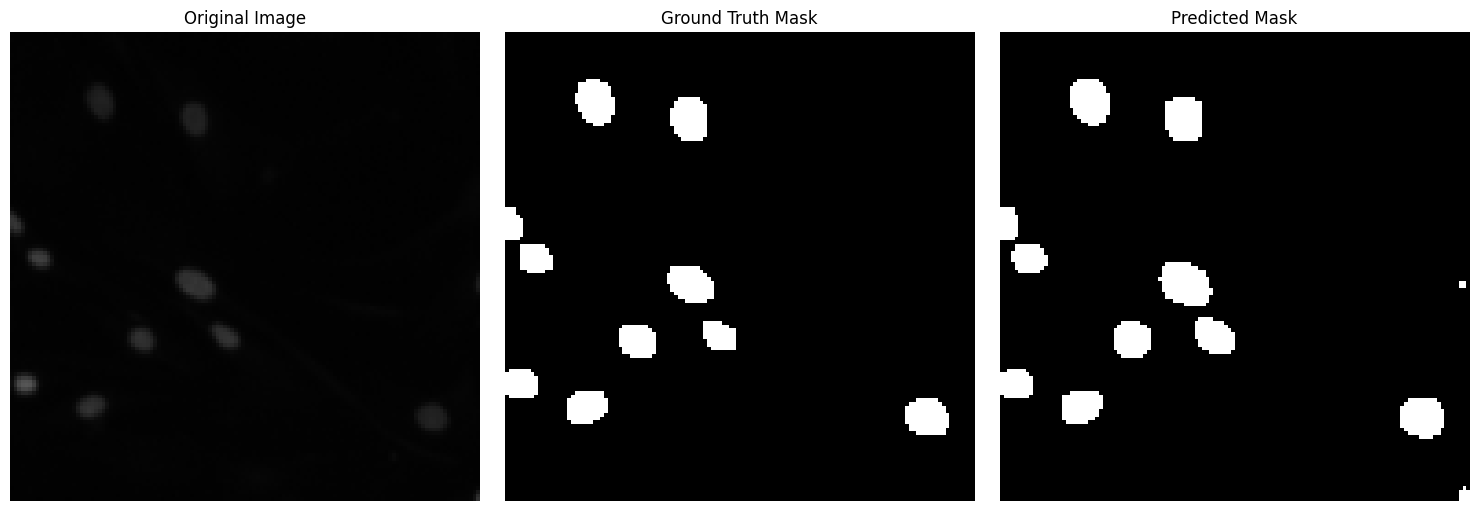

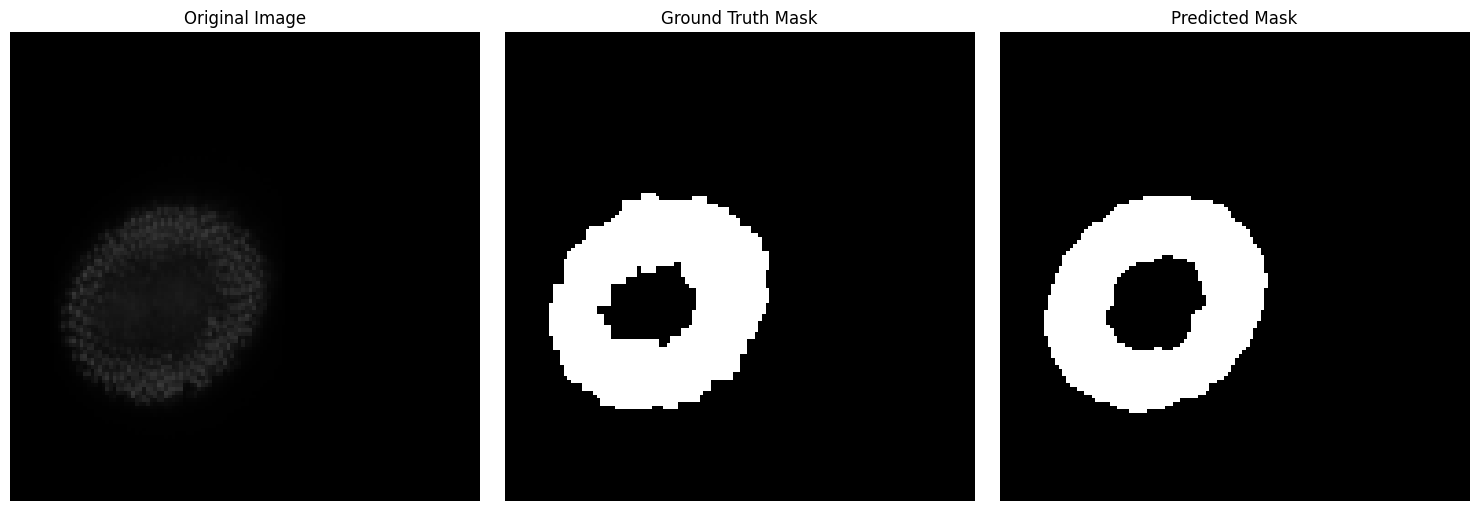

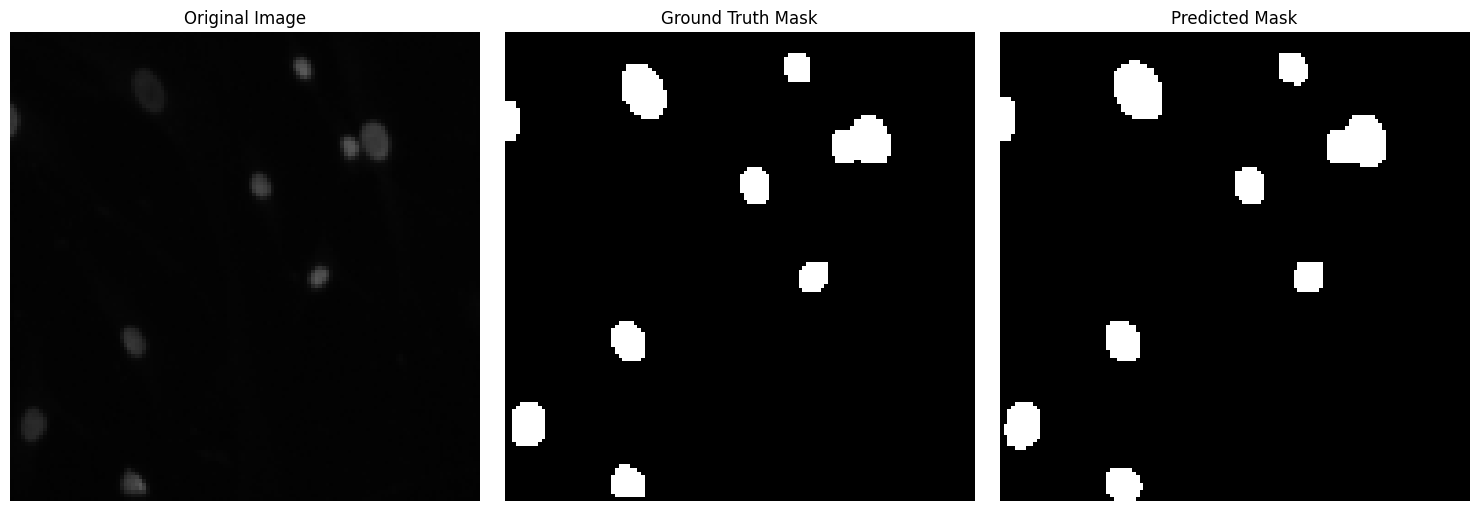

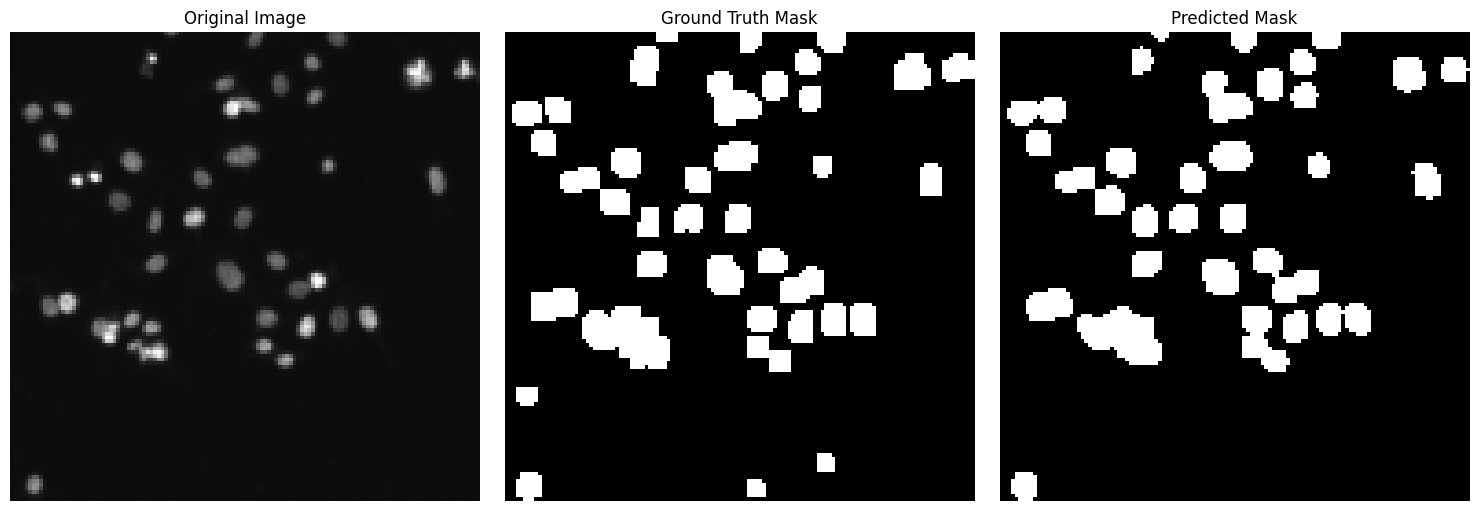

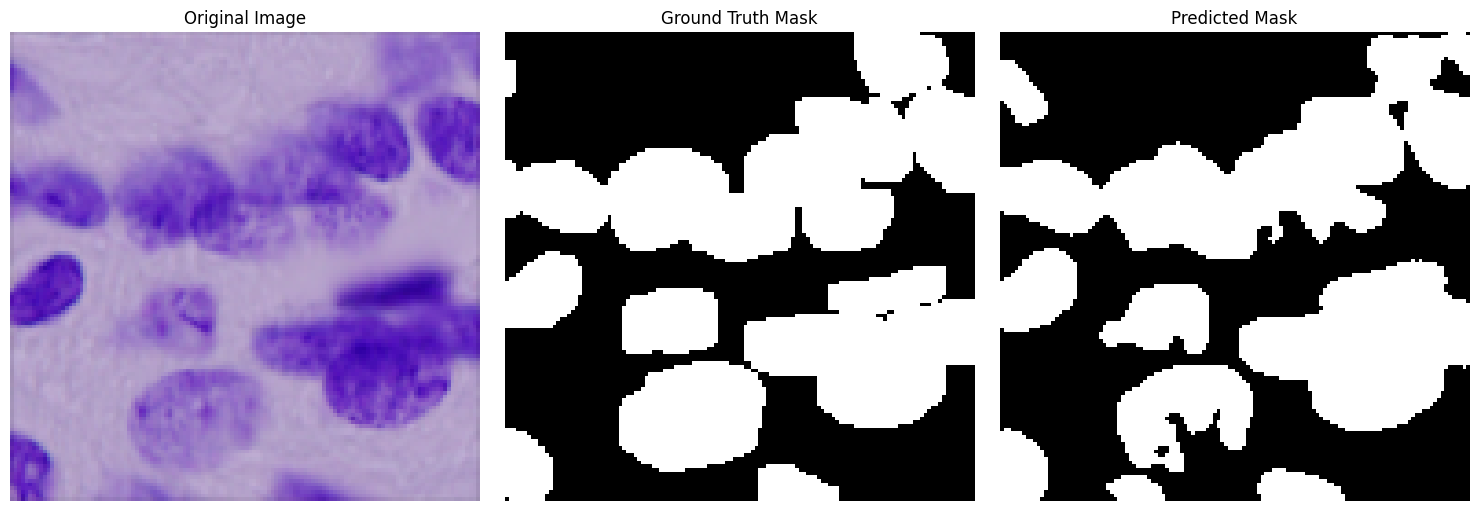

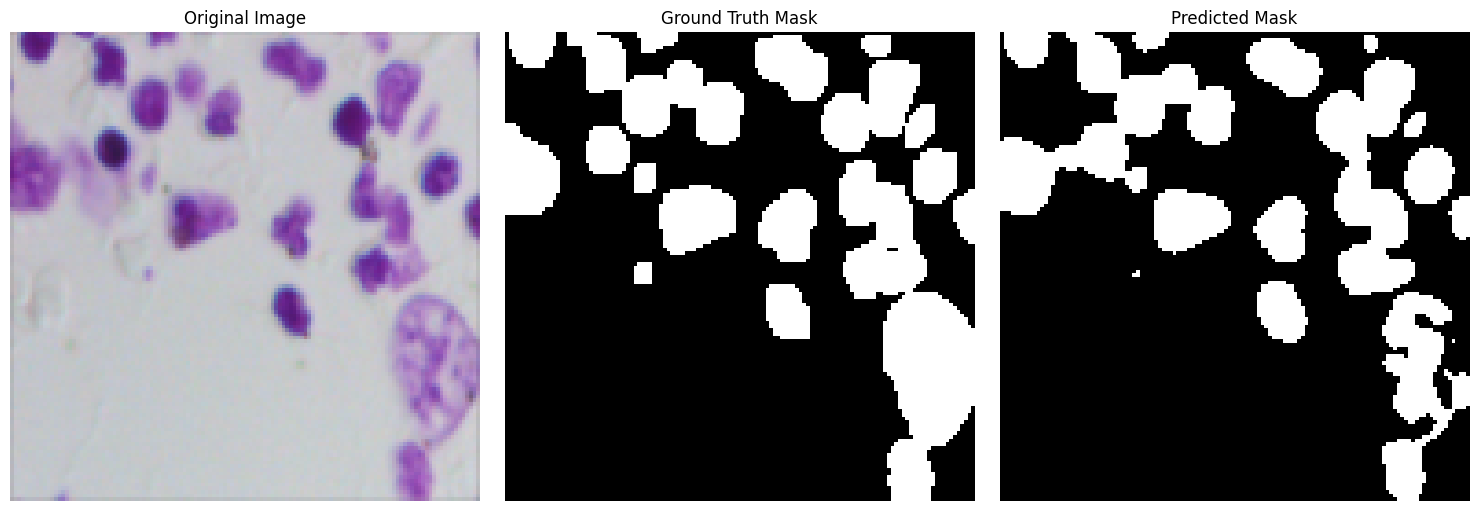

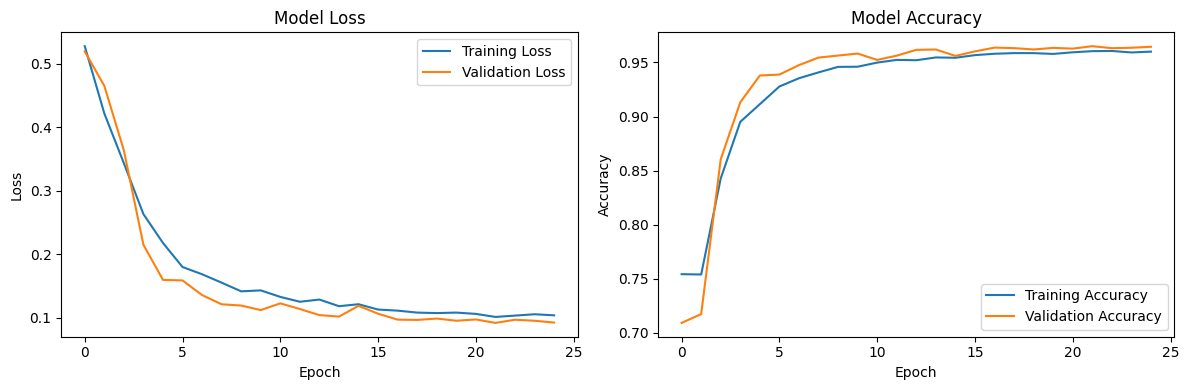

Training completed!


In [ ]:

# Main Execution

if __name__ == "__main__":
    # Load data
    X_train, Y_train, X_test, sizes_test = load_data()

    # Split training data into train and validation
    X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
        X_train, Y_train, test_size=VALIDATION_SPLIT, random_state=SEED
    )

    # Create datasets
    train_dataset = SegmentationDataset(X_train_split, Y_train_split)
    val_dataset = SegmentationDataset(X_val_split, Y_val_split)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Initialize model
    model = UNet(in_channels=IMG_CHANNELS, out_channels=1).to(device)

    # Print model summary
    print("Model Summary:")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Train the model
    print("Starting training...")
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, EPOCHS, device
    )

    # Load best model for inference
    model.load_state_dict(torch.load('/content/best_model.pth'))

    print("Model loaded successfully!")
    print(f"Using device: {device}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Make predictions and visualize
    print("Generating predictions and visualizations...")
    predict_and_visualize(model, X_train_split, Y_train_split, device, num_samples=3)
    predict_and_visualize(model, X_val_split, Y_val_split, device, num_samples=3)

    # Plot training history
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print("Training completed!")